In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
BASE_PATH = r"...\TPC-LoS-prediction-master\data\mimic_subset" # Modify the ... to correct path

icustays = pd.read_csv(
    f"{BASE_PATH}/icustays.csv.gz", 
    compression='gzip',
    dtype={'subject_id': 'int32', 'hadm_id': 'int32'}
)
patients = pd.read_csv(
    f"{BASE_PATH}/patients.csv.gz",
    compression='gzip',
    dtype={'subject_id': 'int32', 'anchor_age': 'int8'}
)
admissions = pd.read_csv(
    f"{BASE_PATH}/admissions.csv.gz",
    compression='gzip',
    dtype={'subject_id': 'int32', 'hadm_id': 'int32'}
)

In [38]:
cohort = (
icustays
    .merge(patients[["subject_id", "gender", "anchor_age"]], 
            on="subject_id", how="inner")
    .merge(admissions[["subject_id", "hadm_id", "race", "insurance"]], 
            on=["subject_id", "hadm_id"], how="inner")
)

# Convert datetimes w/ null check
cohort["intime"] = pd.to_datetime(cohort["intime"], errors='coerce')
cohort["outtime"] = pd.to_datetime(cohort["outtime"], errors='coerce')

# Calculate LoS w/ validation
cohort["los_hours"] = (cohort["outtime"] - cohort["intime"]).dt.total_seconds() / 3600
if cohort["los_hours"].isnull().any():
    print(f"Dropped {cohort['los_hours'].isnull().sum()} invalid LoS records")
    cohort = cohort.dropna(subset=["los_hours"])

# Filtering
cohort = cohort[cohort["los_hours"] <= 1000]
cohort = cohort.sort_values("intime").groupby("subject_id").head(1)

print("Cleaned cohort:", len(cohort), "patients")
print(cohort[["subject_id", "gender", "anchor_age", "race", "insurance", "los_hours"]].head())

Dropped 14 invalid LoS records
Cleaned cohort: 65265 patients
       subject_id gender  anchor_age              race insurance   los_hours
76467    18106347      F          48             WHITE   Private   31.028056
67874    17195991      F          61  UNABLE TO OBTAIN   Private   69.227500
59297    16284044      F          61             WHITE   Private   60.598056
76629    18122666      M          60             WHITE  Medicare   29.776667
51595    15463892      M          83             WHITE  Medicare  119.530278


In [39]:
# Handle missing values
for col in ["gender", "race", "insurance"]:
    cohort[col] = cohort[col].fillna('UNKNOWN').astype('category')

# Encode categorical features
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_cat = encoder.fit_transform(cohort[["gender", "race", "insurance"]])

# Add age and admission hour
X_num = cohort[["anchor_age"]]
X_num["admit_hour"] = cohort["intime"].dt.hour

# Combine features
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)
X_combined = np.hstack([X_cat, X_num_scaled])

y = cohort["los_hours"]
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

C:\Users\jakeh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\jakeh\AppData\Local\Temp\ipykernel_26064\1924083676.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_num["admit_hour"] = cohort["intime"].dt.hour


In [40]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("\n Model Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.1f} hours")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.1f} hours")


 Model Performance:
MAE: 64.6 hours
RMSE: 108.5 hours


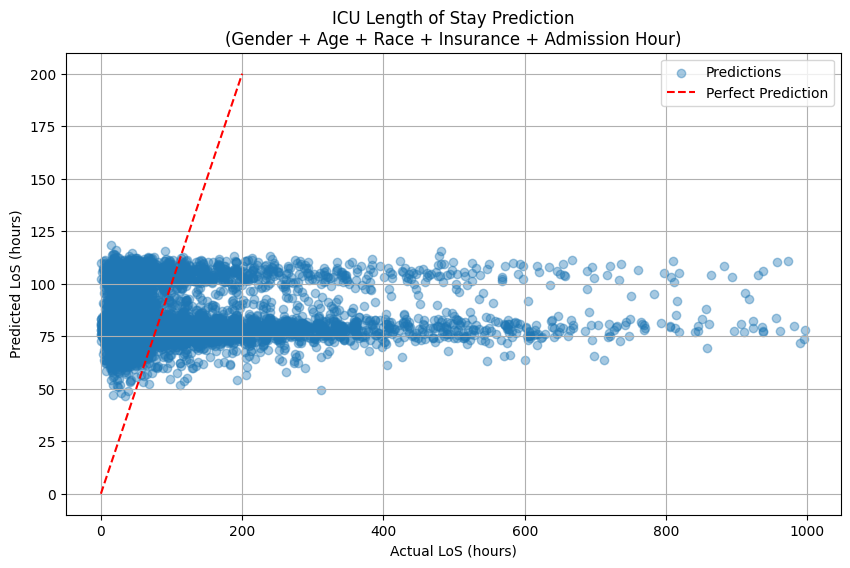

In [41]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.4, label='Predictions')
plt.plot([0, 200], [0, 200], 'r--', label='Perfect Prediction')
plt.xlabel("Actual LoS (hours)")
plt.ylabel("Predicted LoS (hours)")
plt.title("ICU Length of Stay Prediction\n(Gender + Age + Race + Insurance + Admission Hour)")
plt.legend()
plt.grid(True)
plt.show()

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TPCBlock(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.feature_convs = nn.Conv1d(num_features, num_features, kernel_size=3, padding=1, groups=num_features)
        self.mixing_conv = nn.Conv1d(num_features, num_features, kernel_size=1)
        self.norm = nn.BatchNorm1d(num_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        x = x.transpose(1, 2) # (B, F, T)
        x = self.feature_convs(x)
        x = self.mixing_conv(x)
        x = self.norm(x)
        x = self.relu(x)
        x = x.transpose(1, 2) # (B, T, F)
        return x + residual

class TPCNetwork(nn.Module):
    def __init__(self, num_features, num_blocks=3):
        super().__init__()
        self.blocks = nn.Sequential(*[TPCBlock(num_features) for _ in range(num_blocks)])
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(num_features, 1)

    def forward(self, x):
        x = self.blocks(x)
        x = x.transpose(1, 2) # (B, F, T)
        x = self.global_avg_pool(x) # (B, F, 1)
        x = x.squeeze(-1) # (B, F)
        x = self.fc(x).squeeze(-1) # (B,)
        return x

# Create dummy data and DataLoaders
batch_size = 32
time_steps = 48
num_features = 64
num_samples = 1000

X = torch.randn(num_samples, time_steps, num_features)
y = torch.randn(num_samples)

train_size = int(0.8 * num_samples)
val_size = num_samples - train_size
train_dataset, val_dataset = random_split(TensorDataset(X, y), [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

class TPCNetwork(nn.Module):
    def __init__(self, num_features, num_blocks=3, hidden_dim=128):
        super().__init__()

        self.blocks = nn.Sequential(*[
            TPCBlock(num_features) for _ in range(num_blocks)
        ])

        self.global_pool = nn.AdaptiveAvgPool1d(1) # Pool over time

        self.fc = nn.Sequential(
            nn.Flatten(),  # (B, F, 1) → (B, F)
            nn.Linear(num_features, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, 1) # Predict LoS
        )

    def forward(self, x):
        x = self.blocks(x)
        x = x.transpose(1, 2)
        x = self.global_pool(x)

        out = self.fc(x)
        return out.squeeze(-1)

In [43]:
model = TPCNetwork(num_features=64)
x = torch.randn(32, 48, 64) # 32 patients, 48 hours, 64 features
out = model(x)
print(out.shape) # torch.Size([32])

torch.Size([32])


In [44]:
import torch
import torch.nn as nn

num_features = 64
time_steps = 48
batch_size = 8

model = TPCNetwork(num_features=num_features)
print(model)

x_dummy = torch.randn(batch_size, time_steps, num_features)
output = model(x_dummy)

print("Input shape:", x_dummy.shape)
print("Output shape:", output.shape)

# Loss computation
target = torch.randn(batch_size)
criterion = nn.MSELoss()
loss = criterion(output, target)

print("Example loss value:", loss.item())

TPCNetwork(
  (blocks): Sequential(
    (0): TPCBlock(
      (feature_convs): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), groups=64)
      (mixing_conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): TPCBlock(
      (feature_convs): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), groups=64)
      (mixing_conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): TPCBlock(
      (feature_convs): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), groups=64)
      (mixing_conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
  )
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (fc):

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TPCNetwork(num_features=num_features).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

best_val_loss = float('inf')
save_path = 'best_tpc_model.pt'

num_epochs = 20

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Train
    model.train()
    train_loss = 0.0

    for batch_X, batch_y in tqdm(train_loader, desc="Training"):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_X.size(0)

    train_loss /= len(train_loader.dataset)

    # Validate
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_X, batch_y in tqdm(val_loader, desc="Validation"):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            output = model(batch_X)
            loss = criterion(output, batch_y)

            val_loss += loss.item() * batch_X.size(0)

    val_loss /= len(val_loader.dataset)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
        print(f"Best model saved with val loss: {val_loss:.4f}")

Epoch 1/20


Validation: 100%|██████████| 7/7 [00:00<00:00, 607.72it/s]


Train Loss: 1.0309 | Val Loss: 0.9591
Best model saved with val loss: 0.9591
Epoch 2/20


Validation: 100%|██████████| 7/7 [00:00<00:00, 735.92it/s]


Train Loss: 0.9944 | Val Loss: 0.9152
Best model saved with val loss: 0.9152
Epoch 3/20


Validation: 100%|██████████| 7/7 [00:00<00:00, 559.36it/s]


Train Loss: 1.0105 | Val Loss: 0.9156
Epoch 4/20


Validation: 100%|██████████| 7/7 [00:00<00:00, 626.84it/s]


Train Loss: 0.9490 | Val Loss: 0.9237
Epoch 5/20


Validation: 100%|██████████| 7/7 [00:00<00:00, 517.64it/s]


Train Loss: 0.9070 | Val Loss: 1.0555
Epoch 6/20


Validation: 100%|██████████| 7/7 [00:00<00:00, 559.40it/s]


Train Loss: 0.8949 | Val Loss: 0.9607
Epoch 7/20


Validation: 100%|██████████| 7/7 [00:00<00:00, 665.22it/s]


Train Loss: 0.8464 | Val Loss: 0.9884
Epoch 8/20


Validation: 100%|██████████| 7/7 [00:00<00:00, 608.03it/s]


Train Loss: 0.7616 | Val Loss: 1.0020
Epoch 9/20


Validation: 100%|██████████| 7/7 [00:00<00:00, 602.63it/s]


Train Loss: 0.6661 | Val Loss: 1.1041
Epoch 10/20


Validation: 100%|██████████| 7/7 [00:00<00:00, 629.18it/s]


Train Loss: 0.5649 | Val Loss: 1.0890
Epoch 11/20


Validation: 100%|██████████| 7/7 [00:00<00:00, 698.77it/s]


Train Loss: 0.4489 | Val Loss: 1.1326
Epoch 12/20


Validation: 100%|██████████| 7/7 [00:00<00:00, 546.26it/s]


Train Loss: 0.3371 | Val Loss: 1.1999
Epoch 13/20


Validation: 100%|██████████| 7/7 [00:00<00:00, 735.71it/s]


Train Loss: 0.2412 | Val Loss: 1.3812
Epoch 14/20


Validation: 100%|██████████| 7/7 [00:00<00:00, 628.02it/s]


Train Loss: 0.2019 | Val Loss: 1.1791
Epoch 15/20


Validation: 100%|██████████| 7/7 [00:00<00:00, 677.89it/s]


Train Loss: 0.1221 | Val Loss: 1.2115
Epoch 16/20


Validation: 100%|██████████| 7/7 [00:00<00:00, 736.05it/s]


Train Loss: 0.1073 | Val Loss: 1.2713
Epoch 17/20


Validation: 100%|██████████| 7/7 [00:00<00:00, 608.10it/s]


Train Loss: 0.1026 | Val Loss: 1.2523
Epoch 18/20


Validation: 100%|██████████| 7/7 [00:00<00:00, 607.90it/s]


Train Loss: 0.0980 | Val Loss: 1.2333
Epoch 19/20


Validation: 100%|██████████| 7/7 [00:00<00:00, 608.12it/s]


Train Loss: 0.0550 | Val Loss: 1.2458
Epoch 20/20


Validation: 100%|██████████| 7/7 [00:00<00:00, 582.42it/s]

Train Loss: 0.0741 | Val Loss: 1.4690


In [46]:
class TPCBlock(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.feature_convs = nn.Conv1d(num_features, num_features, kernel_size=3, padding=1, groups=num_features)
        self.mixing_conv = nn.Conv1d(num_features, num_features, kernel_size=1)
        self.norm = nn.BatchNorm1d(num_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        x = x.transpose(1, 2)
        x = self.feature_convs(x)
        x = self.mixing_conv(x)
        x = self.norm(x)
        x = self.relu(x)
        x = x.transpose(1, 2)
        return x + residual

class TPCNetwork(nn.Module):
    def __init__(self, num_features, num_blocks=3):
        super().__init__()
        self.blocks = nn.Sequential(*[TPCBlock(num_features) for _ in range(num_blocks)])
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(num_features, 1)

    def forward(self, x):
        x = self.blocks(x)
        x = x.transpose(1, 2)
        x = self.global_avg_pool(x)
        x = x.squeeze(-1)
        x = self.fc(x).squeeze(-1)
        return x

In [48]:
# Hyperparams
batch_size = 32
time_steps = 48
num_features = 64
num_samples = 1000

# Dummy data
X = torch.randn(num_samples, time_steps, num_features)
y = torch.randn(num_samples)

# Train/validation split
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size
train_dataset, val_dataset = random_split(TensorDataset(X, y), [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = TPCNetwork(num_features=num_features).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training parameters
num_epochs = 20
best_val_loss = float('inf')
save_path = 'best_tpc_model.pt'

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    # Training
    model.train()
    train_loss = 0.0

    for batch_X, batch_y in tqdm(train_loader, desc="Training", leave=False):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    mae_sum = 0.0
    rmse_sum = 0.0
    with torch.no_grad():
        for batch_X, batch_y in tqdm(val_loader, desc="Validation", leave=False):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)

            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_X.size(0)

            # Calculate MAE and RMSE
            abs_error = torch.abs(outputs - batch_y)
            mae_sum += abs_error.sum().item()
            squared_error = (outputs - batch_y) ** 2
            rmse_sum += squared_error.sum().item()

    # Calc avg metrics
    val_loss /= len(val_loader.dataset)
    mae = mae_sum / len(val_loader.dataset)
    rmse = np.sqrt(rmse_sum / len(val_loader.dataset))

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
        print(f"Best model saved with Val Loss: {val_loss:.4f}")

Using device: cpu

Epoch 1/20


Train Loss: 1.2718 | Val Loss: 1.0446 | MAE: 0.8133 | RMSE: 1.0220
Best model saved with Val Loss: 1.0446

Epoch 2/20


Train Loss: 0.8943 | Val Loss: 0.9757 | MAE: 0.8010 | RMSE: 0.9878
Best model saved with Val Loss: 0.9757

Epoch 3/20


Train Loss: 0.8481 | Val Loss: 0.9797 | MAE: 0.8005 | RMSE: 0.9898

Epoch 4/20


Train Loss: 0.8122 | Val Loss: 0.9796 | MAE: 0.8034 | RMSE: 0.9898

Epoch 5/20


Train Loss: 0.7795 | Val Loss: 0.9899 | MAE: 0.8091 | RMSE: 0.9950

Epoch 6/20


Train Loss: 0.7373 | Val Loss: 1.0037 | MAE: 0.8142 | RMSE: 1.0019

Epoch 7/20


Train Loss: 0.6948 | Val Loss: 1.0178 | MAE: 0.8219 | RMSE: 1.0089

Epoch 8/20


Train Loss: 0.6523 | Val Loss: 1.0243 | MAE: 0.8218 | RMSE: 1.0121

Epoch 9/20


Train Loss: 0.5937 | Val Loss: 1.0418 | MAE: 0.8327 | RMSE: 1.0207

Epoch 10/20


Train Loss: 0.5450 | Val Loss: 1.0814 | MAE: 0.8521 | RMSE: 1.0399

Epoch 11/20


Train Loss: 0.4964 | Val Loss: 1.0803 | MAE: 0.8486 | RMSE: 1.0394

Epoch 12/20


Train Loss: 0.4259 | Val Loss: 1.2154 | MAE: 0.9118 | RMSE: 1.1025

Epoch 13/20


Train Loss: 0.3702 | Val Loss: 1.1294 | MAE: 0.8744 | RMSE: 1.0627

Epoch 14/20


Train Loss: 0.3001 | Val Loss: 1.2543 | MAE: 0.9231 | RMSE: 1.1200

Epoch 15/20


Train Loss: 0.2367 | Val Loss: 1.2062 | MAE: 0.8850 | RMSE: 1.0983

Epoch 16/20


Train Loss: 0.1828 | Val Loss: 1.2795 | MAE: 0.8861 | RMSE: 1.1311

Epoch 17/20


Train Loss: 0.1662 | Val Loss: 1.2307 | MAE: 0.9076 | RMSE: 1.1094

Epoch 18/20


Train Loss: 0.1190 | Val Loss: 1.2700 | MAE: 0.9171 | RMSE: 1.1269

Epoch 19/20


Train Loss: 0.0985 | Val Loss: 1.2962 | MAE: 0.9296 | RMSE: 1.1385

Epoch 20/20


Train Loss: 0.0656 | Val Loss: 1.2878 | MAE: 0.9185 | RMSE: 1.1348


In [51]:
# Load best model for eval
model.load_state_dict(torch.load('best_tpc_model.pt'))
model.eval()

TPCNetwork(
  (blocks): Sequential(
    (0): TPCBlock(
      (feature_convs): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), groups=64)
      (mixing_conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): TPCBlock(
      (feature_convs): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), groups=64)
      (mixing_conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): TPCBlock(
      (feature_convs): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), groups=64)
      (mixing_conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
  )
  (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
  (

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TPCBlock(nn.Module):
    def __init__(self, num_features):
        super(TPCBlock, self).__init__()
        self.temporal_conv = nn.Conv1d(num_features, num_features, kernel_size=3, padding=1, groups=num_features)
        self.feature_mixing = nn.Conv1d(num_features, num_features, kernel_size=1)
        self.bn = nn.BatchNorm1d(num_features)

    def forward(self, x):
        residual = x
        x = self.temporal_conv(x)
        x = self.feature_mixing(x)
        x = self.bn(x)
        x = F.relu(x)
        return x + residual

class TPCNetworkWithStatic(nn.Module):
    def __init__(self, num_features, static_dim, hidden_dim=128):
        super(TPCNetworkWithStatic, self).__init__()
        self.tpc_blocks = nn.Sequential(
            TPCBlock(num_features),
            TPCBlock(num_features),
            TPCBlock(num_features)
        )

        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.static_fc = nn.Sequential(
            nn.Linear(static_dim, 32),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(num_features + 32, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x, static_features):
        x = x.permute(0, 2, 1)
        x = self.tpc_blocks(x)
        x = self.global_pool(x).squeeze(-1)

        static = self.static_fc(static_features)

        x = torch.cat([x, static], dim=1)
        out = self.fc(x).squeeze(-1)
        return out

In [53]:
batch_size = 16
time_steps = 48
num_features = 35
static_dim = 2

model = TPCNetworkWithStatic(num_features, static_dim)
x_time = torch.randn(batch_size, time_steps, num_features)
x_static = torch.tensor([[25.0, 1.0]] * batch_size) # Age, Gender (1 = male)

output = model(x_time, x_static)
print(output.shape)

torch.Size([16])
